# Static potential:circuit and hamiltonian

In [10]:
import qiskit

In [11]:
from scipy.sparse.linalg import eigsh
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../../") # go to parent dir
from itertools import permutations
import primme

In [12]:
from Hamiltonian_QED_sym import HamiltonianQED_sym
from Hamiltonian_QED_oprt import HamiltonianQED_oprt
from HC_Lattice import HCLattice
from Ansaetze import Ansatz


In [13]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit import Parameter
import qiskit.quantum_info as qinf

##### Class Hamilt

In [14]:
#class input parameters:
n_sites = [3,3]#how many sites for every dimension
g=1
fact_e_op = 1
fact_b_op = 1
m=3
omega=1
l=1
L=8
rotors = False
lambd = 1000
encoding = 'gray' #'ed'#
magnetic_basis=False
pbc=False
puregauge = True 
static_charges_values =None#{(0,0):1,(1,0):-1}#TODO: no conditions applied, like charge conservation, etc. For conditions see func_qstatic_dist
display_hamiltonian=False
e_op_out_plus=False #if E out of site n has plus sign 
sparse_pauli=False
#lattice
latt = HCLattice(n_sites,pbc=pbc,puregauge=puregauge)

static_charges_values_input = latt.distances_coord
print(static_charges_values_input,latt.r_list,set(latt.r_list))

#static charge
qstat=static_charges_values_input[-1]

[{(0, 0): -1, (0, 1): 1} {(0, 0): -1, (0, 2): 1} {(0, 0): -1, (1, 0): 1}
 {(0, 0): -1, (1, 1): 1} {(0, 0): -1, (1, 2): 1} {(0, 0): -1, (2, 0): 1}
 {(0, 0): -1, (2, 1): 1} {(0, 0): -1, (2, 2): 1}] [1.0 2.0 1.0 1.4142135623730951 2.23606797749979 2.0 2.23606797749979
 2.8284271247461903] {1.0, 2.0, 2.23606797749979, 2.8284271247461903, 1.4142135623730951}


In [15]:
# Creating a configuration dictionary with common inputs
config = {
    'latt': latt,
    'n_sites': n_sites,
    'l':l,
    'L':L,
    'encoding':encoding,
    'magnetic_basis': magnetic_basis,
    'pbc': pbc,
    'puregauge': puregauge,
    'static_charges_values': qstat,
    'e_op_out_plus': e_op_out_plus
}
hamilt_sym = HamiltonianQED_sym(config)
class_H_oprt = HamiltonianQED_oprt( config,hamilt_sym, sparse_pauli=sparse_pauli)

HamiltonianQED_sym: Initializing...
> Gauss law equations solved
> e_op_free and u_op_free built
>> Gauss law applied and Hamiltonian built.  Execution time: 0.021207809448242188 seconds
HamiltonianQED_oprt: Initializing...
> e_op_free and u_op_free built
> Pauli strings built
>> Hamiltonian built.  Execution time: 2.5759029388427734 seconds
>> Suppression term built.  Execution time: 0.003175973892211914 seconds


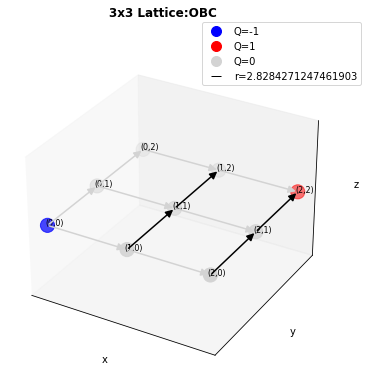

In [16]:
latt.draw_graph_func(gauss_law_fig=True,static_charges=qstat,e_op_free=class_H_oprt.e_op_free) 

In [17]:
Hamiltonian_Pauli_tot_vqd = class_H_oprt.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=0)

#### Circuit

Total n.er of CNOT gates (Toffoli are decomposed): 176
Total n.er of parameters: 32


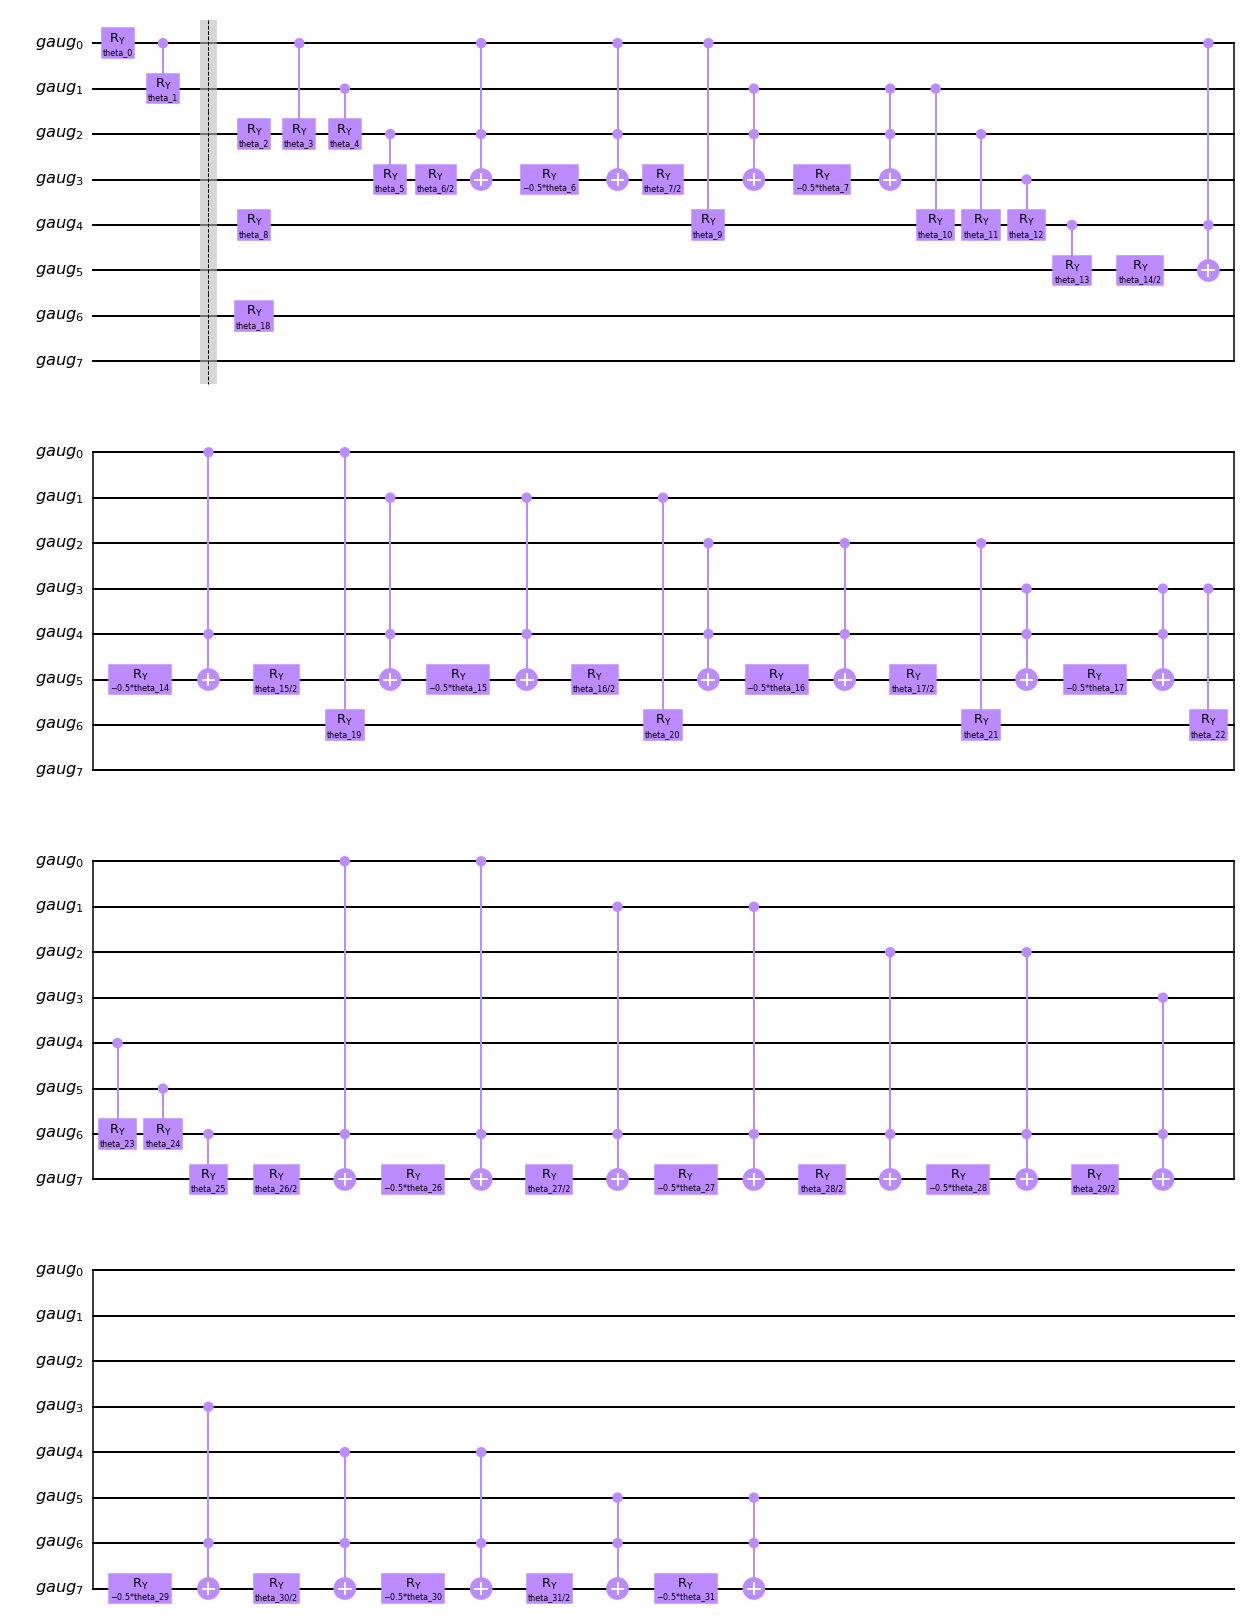

In [19]:
nlayers= 1
entanglement='full'
ngauge = class_H_oprt.len_e_op
if puregauge:
    n_qubits_f = 0
else:
    n_qubits_f = np.prod(latt.n_sites)

n_qubits =int(np.ceil(np.log2(2 * l+ 1)))

ansatz_class = Ansatz(l,ngauge,nfermions=n_qubits_f)

qc_tot2 = ansatz_class.puregauge_circuit_entang(entanglement=entanglement,rzlayer=False,nlayers=nlayers)[0]

print('Total n.er of CNOT gates (Toffoli are decomposed):',dict(qc_tot2.decompose().count_ops())['cx'])
print('Total n.er of parameters:',qc_tot2.num_parameters)
#print(ansatz_class.first_layer_par)
#parameter counts
#ansatz_class.parameters_count(n_qubits,ngauge)
qc_tot2.draw('mpl')